In [1]:
import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
import numpy as np
import pandas as pd
import timeit
import tqdm
import sklearn.metrics
import math

torch.manual_seed(2)

In [2]:
%load_ext Cython

In [3]:
%%cython

import numpy as np
np.get_include() # do we need this on colab? 
cimport cython
cimport numpy as np

cdef dict bases={ 'A':<int>0, 'C':<int>1, 'G':<int>2, 'T':<int>3, 'N':<int>4, } 

@cython.boundscheck(False)
def one_hot( str string ):
    cdef np.ndarray[np.float32_t, ndim=2] res = np.zeros( (5,len(string)), dtype=np.float32 )
    cdef int j
    for j in range(len(string)):
        if string[j] in bases: # bases can be 'N' signifying missing: this corresponds to all 0 in the encoding
            res[ bases[ string[j] ], j ]=float(1.0)
    return(res)


In [4]:
x_np = one_hot("CCGCGNGGNGGCAGNNNNN") #ACGTN
x_tensor = torch.tensor(x_np)
print(x_tensor.shape)
torch.sum(x_tensor, 1)

torch.Size([5, 19])


tensor([1., 4., 7., 0., 7.])

In [5]:
data_dir = './data/'
train_data = pd.read_csv(data_dir + 'anchor_datasets/anchor_master_train.csv')
val_data = pd.read_csv(data_dir + 'anchor_datasets/anchor_master_val.csv')
test_data = pd.read_csv(data_dir + 'anchor_datasets/anchor_master_test.csv')

In [6]:
train_data.head()

,Unnamed: 0,chrom,start,end,anchor
0,21160,chr11,126260165,126264165,1
1,7138,chr3,127812310,127816310,1
2,32125,chr22,21981895,21985895,1
3,27254,chr17,4633544,4637544,1
4,12346,chr6,86883220,86887220,1


In [7]:
import pickle
genome = pickle.load(open(data_dir+"hg38-003.pkl","rb"))

In [8]:
genome["chr6"][42035500:42039500]

'GGGACTACAGGTGCCCACTACCACGCCTGGCTAATTTTTTGTATTTTCAGTAGAGACGGGGTTTCACTGTGTTAGCCAGGATGGTCTCGATCTCCTGACCTCGTGATCCGCCCACCTCAGCCTCCCAAAGTGCTAGGATTACAGGTGTTAGCCACCGTGCCCAGCTAGTTTCTTTTCTTTTCTTTTTTTTTTTTTGAGCCGGAGTCTCACTCTGTCTCCCAGGCCAGAGTACAGTAGCGCGATCTCGGCTCACTGCAACCTCCACCTCCAGGGTTCAAGCAATTCTCCTGCCTCAGCCTCCCAAGTAGCTGGGATTACAGACACCCGCCACAACGCCTGGCTAATTTTTGTATTTTTAGTAGAGACGGGGTTTCACCATTTTGGCCAGGCTGGTTTTGAACTCCTGACTTTGTGATCCCCCCACCTCGGCCTCCCAAAGTGCTGGGATTATAGGTGTGAGCCATCACTCCCGGCCTAAAAATTATTATTATTATTTTGGGTTTTTTTTGAGACAGAGTCTTGCTCTGTCACCCAGGCTGGAGTGCATTGGCCCAATGTTAGCTTGCTGCGCAACCTCTGCCTCTCGGGTTCAAGCGATTCTGCTGCCTCCACCTCCCAAGTAGTTGGGATTATAGGCATGTGCCATCATGCCCAGCTAATTCTTGTATTTTCAGTAGACATGTGGTTTCACCATGTTGGCCAGGCTAGTCCTGAACTCCTGACCTCAAGTGATCCATCTGCCTCGGCCTCCCAAAGTGCTGGGATTACAGGTGTGAGCCACCATGCCTGGCCTAAAAATTATTATTTATATATATATATATATAAAATATATATATGGAGCCTTGCTCTTGTTGCCCAGGCTGGAGTGCATATATACTATATATATATATATATATATATATATTTTTTTTTTTTTTTTTTTTTTTTGACACAGGGTCTCCCTCTGTCACCCAGGCTGGAGTGCAGTGGCACAATCACTACTCACTGCAGCCTCCACCT

In [9]:
len(genome["chr10"])

133797422

In [10]:
cnt=0

context_length = 4000
for i,row in enumerate(test_data.itertuples()):
    midpoint = int(.5 * (row.start + row.end))
    seq = genome[row.chrom][midpoint - context_length//2:midpoint + context_length//2]
    if(np.isnan(row.anchor)):
        cnt += 1
    else:
        pass
#         seq2 = genome[row.chrom][row.start:row.end]
#         print(len(seq),len(seq2), row.anchor, len(genome[row.chrom]))
cnt/len(val_data)

0.0

In [11]:
# class AnchorDataset(torch.utils.data.IterableDataset):

#     def __init__(self, anchor_data, genome, rnn_length):
#         super().__init__()
#         self.rnn_len = rnn_length
#         self.anchor_data = anchor_data
#         self.genome = genome
#         self.context_len = 4000
        
#     def __iter__(self): 
#         for i,row in enumerate(self.anchor_data.itertuples()):
#             lab = row.anchor
#             midpoint = int(.5 * (row.start + row.end))
#             seq = self.genome[row.chrom][ midpoint - self.context_len//2:midpoint + self.context_len//2]
#             if len(seq) < self.context_len:
#                 continue
            
#             oh_cnn_seq = one_hot(seq).transpose() # 4k, 5
#             #for rnn
#             rnn_start = int(self.context_len / 2 - self.rnn_len / 2)
#             rnn_end = int(self.context_len / 2 + self.rnn_len / 2)
#             rnn_seq = seq[rnn_start: rnn_end]
#             oh_rnn_seq = one_hot(rnn_seq).transpose()
            
#             yield(oh_cnn_seq, oh_rnn_seq, np.float32(lab))
            

In [12]:
class AnchorDataset(torch.utils.data.Dataset):

    def __init__(self, anchor_data, genome, rnn_length, test_set=False):
        super().__init__()
        self.rnn_len = rnn_length
        self.anchor_data = anchor_data
        self.genome = genome
        self.test_set = test_set
        self.context_len = 4000
        self.processed_data = []
        
        print('Preparing a dataset...')
        for i,row in tqdm.tqdm(enumerate(self.anchor_data.itertuples()), total=len(anchor_data)):
            lab = row.anchor if self.test_set == False else 0
            midpoint = int(.5 * (row.start + row.end))
            seq = self.genome[row.chrom][ midpoint - self.context_len//2:midpoint + self.context_len//2]
            if len(seq) < self.context_len or np.isnan(lab):
                continue
            
            oh_cnn_seq = one_hot(seq).transpose() # 4k, 5
            #for rnn
            rnn_start = int(self.context_len / 2 - self.rnn_len / 2)
            rnn_end = int(self.context_len / 2 + self.rnn_len / 2)
            rnn_seq = seq[rnn_start: rnn_end]
            oh_rnn_seq = one_hot(rnn_seq).transpose()
            self.processed_data.append((oh_cnn_seq, oh_rnn_seq, np.float32(lab)))
        
        
    def __len__(self): 
        return len(self.processed_data)
    
    def __getitem__(self, idx): 
        return self.processed_data[idx]
            

In [19]:
class Anchor_LSTM_Model(nn.Module):
    def __init__(self, in_dim=5, hid_dim=128, out_dim=1):
        super().__init__()
        self.lstm1 = nn.LSTM(in_dim, hid_dim, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(hid_dim * 2, hid_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hid_dim * 2, out_dim)
        
    def forward(self, x):
        batch_size = x.shape[0]
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        return self.fc(x).view(batch_size, -1)

    
class Anchor_CNN_Model(nn.Module):
    def __init__(self, layer1_out=256, layer2_out=512, dropout=0.2):
        super().__init__()
        self.seq_len = 4000
        
        self.layer1 = nn.Sequential(
                        nn.Conv2d(in_channels=1, out_channels=layer1_out, kernel_size=(17,5)),
                        nn.BatchNorm2d(layer1_out),
                        nn.LeakyReLU(0.2),
                        nn.Dropout2d(dropout),
                    )
        
        #dilated conv dilation=1
        self.layer2_1 = nn.Sequential(
                        nn.Conv2d(in_channels=layer1_out, out_channels=layer2_out, kernel_size=(5,1), dilation=1, padding='same'),
                        nn.BatchNorm2d(layer2_out),
                        nn.LeakyReLU(0.2),
                        nn.MaxPool2d(kernel_size=(self.seq_len - 16, 1), stride=(self.seq_len - 16, 1)),
                        nn.Dropout2d(dropout),
                    )
        
        #dilated conv dilation=3
        self.layer2_2 = nn.Sequential(
                        nn.Conv2d(in_channels=layer1_out, out_channels=layer2_out, kernel_size=(5,1), dilation=3, padding='same'),
                        nn.BatchNorm2d(layer2_out),
                        nn.LeakyReLU(0.2),
                        nn.MaxPool2d(kernel_size=(self.seq_len - 16, 1), stride=(self.seq_len - 16, 1)),
                        nn.Dropout2d(dropout),
                    )
        
        #dilated conv dilation=7
        self.layer2_3 = nn.Sequential(
                        nn.Conv2d(in_channels=layer1_out, out_channels=layer2_out, kernel_size=(5,1), dilation=7, padding='same'),
                        nn.BatchNorm2d(layer2_out),
                        nn.LeakyReLU(0.2),
                        nn.MaxPool2d(kernel_size=(self.seq_len - 16, 1), stride=(self.seq_len - 16, 1)),
                        nn.Dropout2d(dropout),
                    )
        
    def forward(self, x):
        x = x.unsqueeze(1) #[*, 1, 4k, 5]
        batch_size = x.shape[0]
        x = self.layer1(x)
        o1 = self.layer2_1(x).view(batch_size, -1)
        o2 = self.layer2_2(x).view(batch_size, -1)
        o3 = self.layer2_3(x).view(batch_size, -1)
        out = torch.cat((o1,o2,o3), -1)
        return out
        
        
class Anchor_CNN_LSTM(nn.Module):
    def __init__(self,
                 use_lstm=True,
                 use_cnn=True):
        super().__init__()
        
        out_dim = 0
        self.use_lstm = use_lstm
        self.use_cnn = use_cnn
        
        if use_lstm == True:
            self.lstm_model = Anchor_LSTM_Model()
            out_dim += 800
            
        if use_cnn == True:
            self.cnn_model = Anchor_CNN_Model()
            out_dim += 1536
        
        
        self.classifier = nn.Sequential(
                            nn.Linear(out_dim, 512),
                            nn.BatchNorm1d(512),
                            nn.LeakyReLU(0.2),
                            nn.Dropout(0.2),
            
                            nn.Linear(512, 256),
                            nn.BatchNorm1d(256),
                            nn.LeakyReLU(0.2),
                            nn.Dropout(0.2),
                            
                            nn.Linear(256, 1),
                            nn.Sigmoid()
                        )

    def forward(self, x_cnn, x_rnn):
        if self.use_lstm == True and self.use_cnn == True:
            x2 = self.cnn_model(x_cnn)
            x1 = self.lstm_model(x_rnn)
            x = torch.cat((x2, x1), -1)
        elif self.use_lstm == True:
            x = self.lstm_model(x_rnn)
        elif self.use_cnn == True:
            x = self.cnn_model(x_cnn)

        out = self.classifier(x)

        return out
        

In [20]:
# batch_size = 64
# train_dataset = AnchorDataset(train_data, genome, 800)
# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers = 0) 72302

# val_dataset = AnchorDataset(val_data, genome, 800)
# val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers = 0) 1600

# test_dataset = AnchorDataset(test_data, genome, 800)
# test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers = 0) 5670


In [21]:
def run_one_epoch(train_flag, dataloader, cnn_1d, optimizer, device, dataset_size, epoch):

    torch.set_grad_enabled(train_flag)
    cnn_1d.train() if train_flag else cnn_1d.eval() 

    losses = []
#     accuracies = []
#     auprcs = []
    
    all_ys = []
    all_probs = []
    
    with tqdm.tqdm(enumerate(dataloader), total=(dataset_size), unit="batch") as tepoch:
        for idx, (x_cnn, x_rnn, y) in tepoch: #tqdm.tqdm(enumerate(dataloader), total=dataset_size): # collection of tuples with iterator
            tepoch.set_description(f"Epoch {epoch+1}")
            (x_cnn, x_rnn, y) = ( x_cnn.to(device), x_rnn.to(device), y.to(device) ) # transfer data to GPU

            output = cnn_1d(x_cnn, x_rnn) # forward pass
            output = output.squeeze() # remove spurious channel dimension
            loss = F.binary_cross_entropy( output, y ) # numerically stable

            if train_flag: 
                loss.backward() # back propagation
                optimizer.step()
                optimizer.zero_grad()

            losses.append(loss.detach().cpu().numpy())
            accuracy = torch.mean( ( (output > .5) == (y > .5) ).float() )
#             print('idx',idx, loss.item(), y, output)

            y_np = y.detach().cpu().numpy()
            probs_np = output.detach().cpu().numpy()
        
#             auprc = sklearn.metrics.average_precision_score(y_np, probs_np)
#             auprcs.append(auprc)
#             accuracies.append(accuracy.detach().cpu().numpy())
            
            all_ys.extend(y_np.tolist())
            all_probs.extend(probs_np.tolist())
            
            tepoch.set_postfix(loss=loss.item(), batch_accuracy=100. * accuracy.detach().cpu().numpy())#, batch_auprc=100. * auprc)
            
    all_ys = np.array(all_ys)
    all_probs = np.array(all_probs)
    precision, recall, thresholds = sklearn.metrics.precision_recall_curve(all_ys, all_probs)
    epoch_acc = np.mean( ( (all_probs > .5) == (all_ys > .5) ) )
    
    return( np.mean(losses), epoch_acc, precision, recall)

In [22]:
def train_model(cnn_1d, train_data, validation_data, epochs=15, patience=4, verbose = True):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    cnn_1d = cnn_1d.to(device)

    batch_size = 64
    train_dataset = AnchorDataset(train_data, genome, 800)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers = 0, shuffle=True)
    
    val_dataset = AnchorDataset(val_data, genome, 800)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers = 0)

    optimizer = torch.optim.RMSprop(cnn_1d.parameters())
    
    train_accs = []
    val_accs = []
    patience_counter = patience
    best_val_loss = np.inf
    check_point_filename = 'anchor_model_checkpoint_cnn.pt' # to save the best model fit to date
    for epoch in range(epochs):
        start_time = timeit.default_timer()
        
        train_loss, train_acc, train_pr, train_rec = run_one_epoch(True, train_dataloader, cnn_1d, optimizer, device, math.ceil(len(train_dataset)/batch_size), epoch)
        val_loss, val_acc, val_pr, val_rec = run_one_epoch(False, val_dataloader, cnn_1d, optimizer, device, math.ceil(len(val_dataset)/batch_size), epoch)
        
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        if val_loss < best_val_loss: 
            torch.save(cnn_1d.state_dict(), check_point_filename)
            best_val_loss = val_loss
            patience_counter = patience
        else: 
            patience_counter -= 1
            if patience_counter <= 0: 
                cnn_1d.load_state_dict(torch.load(check_point_filename)) # recover the best model so far
                break
        elapsed = float(timeit.default_timer() - start_time)
        
        if verbose == True:
            train_auprc = sklearn.metrics.auc(train_rec, train_pr)
            val_auprc = sklearn.metrics.auc(val_rec, val_pr)
            print("Epoch %i took %.2fs. Train loss: %.4f acc: %.4f. auprc: %.4f. Val loss: %.4f acc: %.4f. auprc: %.4f. Patience left: %i" % 
                  (epoch+1, elapsed, train_loss, train_acc, train_auprc, val_loss, val_acc, val_auprc, patience_counter ))
    
    return cnn_1d, train_accs, val_accs

In [23]:
my_cnn1d = Anchor_CNN_LSTM(use_cnn=True, use_lstm=False)
my_cnn1d, train_accs, val_accs = train_model(my_cnn1d, train_data, val_data)

  0%|          | 166/72500 [00:00<00:43, 1650.94it/s]

Preparing a dataset...


 10%|█         | 161/1600 [00:00<00:00, 1601.01it/s]

Preparing a dataset...


Epoch 2:   0%|          | 0/1130 [00:00<?, ?batch/s]

Epoch 1 took 1077.81s. Train loss: 0.6407 acc: 0.6304. auprc: 0.5239. Val loss: 0.6875 acc: 0.5725. auprc: 0.7766. Patience left: 4


Epoch 3:   0%|          | 0/1130 [00:00<?, ?batch/s]

Epoch 2 took 1077.12s. Train loss: 0.5999 acc: 0.6711. auprc: 0.5802. Val loss: 0.6941 acc: 0.6181. auprc: 0.7738. Patience left: 3


Epoch 4:   0%|          | 0/1130 [00:00<?, ?batch/s]

Epoch 3 took 1073.27s. Train loss: 0.5930 acc: 0.6783. auprc: 0.5930. Val loss: 0.6187 acc: 0.6950. auprc: 0.7776. Patience left: 4


Epoch 5:   0%|          | 0/1130 [00:00<?, ?batch/s]

Epoch 4 took 1076.10s. Train loss: 0.5891 acc: 0.6821. auprc: 0.5947. Val loss: 0.6761 acc: 0.6356. auprc: 0.7885. Patience left: 3


Epoch 6:   0%|          | 0/1130 [00:00<?, ?batch/s]

Epoch 5 took 1071.31s. Train loss: 0.5848 acc: 0.6851. auprc: 0.6049. Val loss: 0.7151 acc: 0.6100. auprc: 0.7803. Patience left: 2


Epoch 7:   0%|          | 0/1130 [00:00<?, ?batch/s]

Epoch 6 took 1072.67s. Train loss: 0.5826 acc: 0.6891. auprc: 0.6081. Val loss: 0.6716 acc: 0.6600. auprc: 0.7896. Patience left: 1


Epoch 7: 100%|██████████| 25/25 [00:09<00:00,  2.74batch/s, batch_accuracy=32.8, loss=0.792]


### Testing

In [24]:
def test_model(model, testing_data=test_data):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    batch_size = 64
    test_dataset = AnchorDataset(testing_data, genome, 800)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers = 0)
    test_loss, test_acc, test_pr, test_rec = run_one_epoch(False, 
                                                   test_dataloader, 
                                                   model, 
                                                   None, 
                                                   device, 
                                                   math.ceil(len(test_dataset)/batch_size), 
                                                   0)
    test_auprc = sklearn.metrics.auc(test_rec, test_pr)
    return test_pr, test_rec, test_auprc

In [81]:
test_pr, test_rec, test_auprc = test_model(my_cnn1d)

  3%|▎         | 164/5700 [00:00<00:03, 1635.42it/s]

Preparing a dataset...


Epoch 0: 100%|██████████| 75/75 [00:31<00:00,  2.40batch/s, batch_accuracy=85.3, loss=0.405] 


In [79]:
test_auprc

0.9489202174230047

In [27]:
import matplotlib.pyplot as plt

In [28]:
test_data_positives = test_data[test_data['anchor']==1]
test_na1 = pd.read_csv(data_dir + 'anchor_test_sets/non_anchor_type_1.csv')
test_na1 = test_na1[test_na1['chrom'].isin(['chr7', 'chr8'])]
test_na1['anchor']=0.0
test_na1 = test_na1.sample(3666)
final_test_na_1 = test_data_positives.append(test_na1)
final_test_na_1.head()

,Unnamed: 0,chrom,start,end,anchor
0,16263,chr8,135695883,135699883,1.0
1,13665,chr7,37547648,37551648,1.0
2,15599,chr8,72730268,72734268,1.0
3,13650,chr7,36478697,36482697,1.0
4,14432,chr7,122846716,122850716,1.0


In [29]:
# test_na2 = pd.read_csv(data_dir + 'anchor_test_sets/non_anchor_type_2.csv')
# test_na3 = pd.read_csv(data_dir + 'anchor_test_sets/non_anchor_type_3.csv')

In [45]:
test_pr1, test_rec1, test_auprc1 = test_model(my_cnn1d, final_test_na_1)

  2%|▏         | 150/6666 [00:00<00:04, 1494.66it/s]

Preparing a dataset...


Epoch 1: 100%|██████████| 104/104 [00:38<00:00,  2.73batch/s, batch_accuracy=60, loss=0.618]  


In [46]:
test_auprc1

0.7485348060179605

In [33]:
test_data_positives = test_data[test_data['anchor']==1]
test_na2 = pd.read_csv(data_dir + 'anchor_test_sets/non_anchor_type_2.csv')
test_na2 = test_na2[test_na2['chrom'].isin(['chr7', 'chr8'])]
test_na2['anchor']=0.0
test_data_positives = test_data_positives.sample(643)
final_test_na_2 = test_data_positives.append(test_na2)
final_test_na_2.head()

,Unnamed: 0,chrom,start,end,anchor
2723,13800,chr7,49890363,49894363,1.0
1091,16153,chr8,126711477,126717011,1.0
252,15004,chr8,12722740,12727768,1.0
1328,15056,chr8,19969379,19973379,1.0
1801,15536,chr8,66472475,66476475,1.0


In [34]:
test_pr2, test_rec2, test_auprc2 = test_model(my_cnn1d, final_test_na_2)
test_auprc2

  3%|▎         | 145/5364 [00:00<00:03, 1449.33it/s]

Preparing a dataset...


Epoch 1: 100%|██████████| 84/84 [00:30<00:00,  2.73batch/s, batch_accuracy=97.9, loss=0.292]


0.9006655014853501

In [35]:
test_data_positives = test_data[test_data['anchor']==1]
test_na3 = pd.read_csv(data_dir + 'anchor_test_sets/non_anchor_type_2.csv')
test_na3 = test_na2[test_na2['chrom'].isin(['chr7', 'chr8'])]
test_na3['anchor']=0.0
test_data_positives = test_data_positives.sample(382)
final_test_na_3 = test_data_positives.append(test_na3)
final_test_na_3.head()

,Unnamed: 0,chrom,start,end,anchor
1226,16321,chr8,142035186,142039186,1.0
904,16011,chr8,113811787,113815787,1.0
251,16416,chr8,145732797,145736797,1.0
1076,15088,chr8,22286195,22290195,1.0
2263,14078,chr7,93850230,93854230,1.0


In [36]:
test_pr3, test_rec3, test_auprc3 = test_model(my_cnn1d, final_test_na_3)
test_auprc3

  3%|▎         | 161/5103 [00:00<00:03, 1602.84it/s]

Preparing a dataset...


Epoch 1: 100%|██████████| 80/80 [00:29<00:00,  2.74batch/s, batch_accuracy=97.8, loss=0.296]


0.8537587682438184

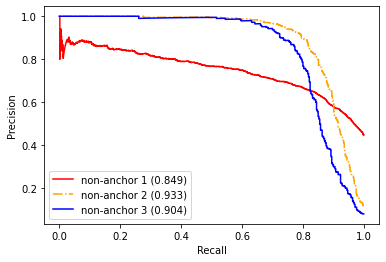

In [37]:
plt.plot(test_rec1, test_pr1, color="red", linestyle='-', label=f'non-anchor 1 (0.849)')
plt.plot(test_rec2, test_pr2, color="orange", linestyle='-.', label=f'non-anchor 2 (0.933)')
plt.plot(test_rec3, test_pr3, color="blue", linestyle='-', label=f'non-anchor 3 (0.904)')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [ ]:
#evaluate on lstm+cnn then make the plot

In [38]:
model1 = Anchor_CNN_LSTM(use_cnn=True, use_lstm=True).to("cuda")
model1.load_state_dict(torch.load('./data/anchor_model_checkpoint_lstm_cnn.pt'))

<All keys matched successfully>

In [39]:
m1_test_pr1, m1_test_rec1, m1_test_auprc1 = test_model(model1, final_test_na_1)

  2%|▏         | 164/6666 [00:00<00:03, 1635.83it/s]

Preparing a dataset...


Epoch 1: 100%|██████████| 104/104 [00:43<00:00,  2.37batch/s, batch_accuracy=28.9, loss=1.16] 


In [40]:
m1_test_auprc1, 

(0.8318950634519268,)

In [41]:
model2 = Anchor_CNN_LSTM(use_cnn=False, use_lstm=True).to("cuda")
model2.load_state_dict(torch.load('./data/anchor_model_checkpoint_lstm.pt'))

<All keys matched successfully>

In [42]:
m2_test_pr1, m2_test_rec1, m2_test_auprc1 = test_model(model2, final_test_na_1)

  2%|▏         | 143/6666 [00:00<00:04, 1428.35it/s]

Preparing a dataset...


Epoch 1: 100%|██████████| 104/104 [00:05<00:00, 18.04batch/s, batch_accuracy=0, loss=1.13]   


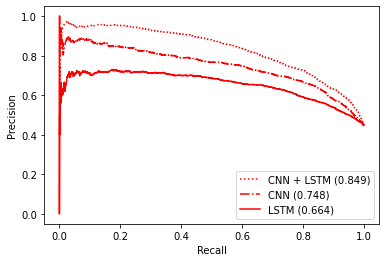

In [48]:
plt.plot(m1_test_rec1, m1_test_pr1, color="red", linestyle=':', label=f'CNN + LSTM (0.849)')
plt.plot(test_rec1, test_pr1, color="red", linestyle='-.', label=f'CNN (0.748)')
plt.plot(m2_test_rec1, m2_test_pr1, color="red", linestyle='-', label=f'LSTM (0.664)')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()